# SalGAN reimplementation
based off: https://arxiv.org/pdf/1701.01081.pdf

Code written for google colab

## google colab imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the file to the local filesystem

!cp -r "/content/drive/MyDrive/General/final project" "/content/ece285"



KeyboardInterrupt: ignored

# Imports

In [ ]:
import torch
from torch import nn
from torchvision.models import vgg16
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
#import torch_directml
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.datasets as datasets
import glob
import os
import numpy as np
import pickle

device = torch.device('cuda')

## Dataloader and Device Setup

In [ ]:
class SaliencyMapDataset(Dataset):
    def __init__(self, root_dirs, transform=None, map_transform=None):
        self.transform = transform
        self.map_transform = map_transform
        self.img_files = []
        for root_dir in root_dirs:
            self.img_files += glob.glob(root_dir + '/*/*.jpg')

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        map_path = os.path.join(os.path.dirname(img_path), 'Output', os.path.basename(img_path).replace('.jpg', '_SaliencyMap.jpg'))

        image = Image.open(img_path).convert('RGB')  # Convert image to RGB
        saliency_map = Image.open(map_path).convert('L')  # Convert saliency map to grayscale

        if self.transform:
            image = self.transform(image)
        if self.map_transform:
            saliency_map = self.map_transform(saliency_map)

        return image, saliency_map

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

map_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dirs = [
    '/content/ece285/trainSet/Stimuli',
    '/content/ece285/testSet/Stimuli'
]

saliency_map_dataset = SaliencyMapDataset(root_dirs=dirs, transform=image_transform, map_transform=map_transform)

len_dataset = len(saliency_map_dataset)
len_train = int(0.8 * len_dataset)
len_val = int(0.1 * len_dataset)
len_test = len_dataset - len_train - len_val

torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(saliency_map_dataset, [len_train, len_val, len_test])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



## Model architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        vgg = vgg16(pretrained=True)
        self.encoder = nn.Sequential(*list(vgg.features.children())[:-1]) # remove last pooling layer
        self.decoder = self.make_decoder()

    def make_decoder(self):
        decoder = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv6_1
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv6_2
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv6_3
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  # upsample6

        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv7_1
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv7_2
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv7_3
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  # upsample7

        nn.Conv2d(512, 256, kernel_size=3, padding=1),  # conv8_1
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),  # conv8_2
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),  # conv8_3
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  # upsample8

        nn.Conv2d(256, 128, kernel_size=3, padding=1),  # conv9_1
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),  # conv9_2
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  # upsample9

        nn.Conv2d(128, 64, kernel_size=3, padding=1),  # conv10_1
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),  # conv10_2
        nn.ReLU(),

        nn.Conv2d(64, 1, kernel_size=1),  # output
        nn.Sigmoid()
        )

        return decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #this first layer is needed for training. In training, the images and saliency maps
        #are concatenated so we get a 4 channel input rataher than 3 chanel rgb
        self.first_layer = nn.Conv2d(4, 64, kernel_size=3, stride=2, padding=1)
        self.conv_layers = self.make_conv_layers()
        self.fc_layers = self.make_fc_layers()

    def make_conv_layers(self):
        conv_layers = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # conv1_2
            nn.ReLU(),
            nn.MaxPool2d(stride=2, kernel_size=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # conv2_1
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # conv2_2
            nn.ReLU(),
            nn.MaxPool2d(stride=2, kernel_size=2, padding=0),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # conv3_1
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # conv3_2
            nn.ReLU(),
            nn.MaxPool2d(stride=2, kernel_size=2, padding=0),
        )
        return conv_layers

    def make_fc_layers(self):
        fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 100),  # fc4
            nn.Tanh(),
            nn.Linear(100, 2),  # fc5
            nn.Tanh(),
            nn.Linear(2, 1),  # fc6
            nn.Sigmoid()
        )
        return fc_layers

    def forward(self, x):
        x = self.first_layer(x)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.fc_layers(x)
        return x


## Training and Validation architecture

In [ ]:
def calculate_information_gain(pred_map, true_map, eps=1e-10):
    # Flatten the predicted and ground truth saliency maps
    pred_map = pred_map.view(-1)
    true_map = true_map.view(-1)

    # Normalize the predicted and true saliency maps to sum up to 1
    pred_map = pred_map / (pred_map.sum() + eps)
    true_map = true_map / (true_map.sum() + eps)

    # Calculate the entropy of the predicted and true saliency maps
    entropy_pred = -(pred_map * torch.log(pred_map + eps)).sum()
    entropy_true = -(true_map * torch.log(true_map + eps)).sum()

    # Calculate the joint entropy of the predicted and true saliency maps
    joint_distribution = pred_map * true_map  # assuming independence
    joint_distribution = joint_distribution / (joint_distribution.sum() + eps)  # normalization

    joint_entropy = -(joint_distribution * torch.log(joint_distribution + eps)).sum()

    # Calculate the information gain
    information_gain = entropy_true - joint_entropy

    return information_gain.item()


def calculate_concordance_correlation(pred_map, true_map):
    pred_map = pred_map.view(-1)
    true_map = true_map.view(-1)

    mu_pred = torch.mean(pred_map)
    mu_true = torch.mean(true_map)

    sigma_pred = torch.std(pred_map)
    sigma_true = torch.std(true_map)

    pred_true_cov = ((pred_map - mu_pred) * (true_map - mu_true)).mean()

    pearson = pred_true_cov / (sigma_pred * sigma_true)
    accuracy = 2 * mu_pred * mu_true / (mu_pred**2 + mu_true**2)
    precision = 2 * sigma_pred * sigma_true / (sigma_pred**2 + sigma_true**2)

    cc = pearson * precision * accuracy

    return cc.item()


def train(model, train_loader, val_loader, epochs=20, alpha=0.005):
    # Define criteria for different losses
    content_criterion = nn.BCELoss()
    adv_criterion = nn.BCELoss()

    metrics = {"IG": [], "CC": []}
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()  # set the model to training mode
        for batch, (images, true_saliency_maps) in enumerate(train_loader):
            images = images.to(device)
            true_saliency_maps = true_saliency_maps.to(device)

            # Forward pass through the encoder and decoder
            encoded = encoder(images)
            pred_saliency_maps = decoder(encoded)

            # Compute the content loss
            content_loss = content_criterion(pred_saliency_maps, true_saliency_maps)

            # Forward pass through the discriminator
            real_outputs = discriminator(torch.cat([images, true_saliency_maps], dim=1))
            fake_outputs = discriminator(torch.cat([images, pred_saliency_maps.detach()], dim=1))

            # Compute the adversarial loss for the discriminator
            adv_loss_dis_real = adv_criterion(real_outputs, Variable(torch.ones(real_outputs.size())).to(device))
            adv_loss_dis_fake = adv_criterion(fake_outputs, Variable(torch.zeros(fake_outputs.size())).to(device))
            adv_loss_dis = (adv_loss_dis_real + adv_loss_dis_fake) / 2

            # Perform backpropagation on the discriminator
            discriminator.zero_grad()
            adv_loss_dis.backward()
            discriminator_optimizer.step()

            # Compute the adversarial loss for the generator
            fake_outputs_for_gen_loss = discriminator(torch.cat([images, pred_saliency_maps], dim=1))
            adv_loss_gen = adv_criterion(fake_outputs_for_gen_loss, Variable(torch.ones(fake_outputs_for_gen_loss.size())).to(device))

            # Combine the losses for the generator and perform backpropagation
            gen_loss = content_loss + alpha * adv_loss_gen
            encoder.zero_grad()
            decoder.zero_grad()
            gen_loss.backward()
            decoder_optimizer.step()
            encoder_optimizer.step()

        print(f"Epoch {epoch + 1}, Content Loss: {content_loss.item()}, Adversarial Loss: {adv_loss_dis.item()}")

        # Start of the validation phase
        model.eval()  # set the model to evaluation mode
        with torch.no_grad():
            total = 0
            correct = 0
            ig_sum = 0.0  # Accumulator for IG scores
            cc_sum = 0.0  # Accumulator for CC accuracy

            for batch, (images, true_saliency_maps) in enumerate(val_loader):
                images = images.to(device)
                true_saliency_maps = true_saliency_maps.to(device)

                # Forward pass through the model
                encoded = encoder(images)
                pred_saliency_maps = decoder(encoded)

                # Calculate accuracy
                _, predicted = torch.max(pred_saliency_maps.data, 1)
                total += true_saliency_maps.size(0)
                correct += (predicted == true_saliency_maps).sum().item()

                # Calculate IG
                # Calculate IG for each sample in the batch and accumulate the sum
                for pred_map, true_map in zip(pred_saliency_maps, true_saliency_maps):
                    ig = calculate_information_gain(pred_map, true_map)
                    ig_sum += ig

                # Calculate CC accuracy
                for pred_map, true_map in zip(pred_saliency_maps, true_saliency_maps):
                    cc = calculate_concordance_correlation(pred_map, true_map)
                    cc_sum += cc

            # Store mean metrics for the epoch
            metrics["IG"].append(ig_sum / total)
            metrics["CC"].append(cc_sum / total)

        print(f"Epoch {epoch + 1}, IG: {metrics['IG'][-1]}, CC: {metrics['CC'][-1]}")


    # Save metrics to a file for future use
    with open('metrics.pkl', 'wb') as f:
        pickle.dump(metrics, f)




# Training

In [ ]:
# Define the model
generator = Generator().to(device)
encoder = generator.encoder
decoder = generator.decoder
discriminator = Discriminator().to(device)

encoder_optimizer = optim.Adagrad(encoder.parameters(), lr=3e-4, weight_decay=1e-4)
decoder_optimizer = optim.Adagrad(decoder.parameters(), lr=3e-4, weight_decay=1e-4)
discriminator_optimizer = optim.Adagrad(discriminator.parameters(), lr=3e-4, weight_decay=1e-4)

criterion = nn.BCELoss()
#hyperparameter from paper
alpha = 0.005
train(generator, train_loader, val_loader, epochs=10, alpha= alpha)


Epoch 1/10
Epoch 1, Content Loss: 0.44413965940475464, Adversarial Loss: 0.699851393699646
Epoch 1, IG: 0.1777621841430664, CC: 0.6321675217244774
Epoch 2/10
Epoch 2, Content Loss: 0.3938395380973816, Adversarial Loss: 0.6994223594665527
Epoch 2, IG: 0.293301477432251, CC: 0.7159116217121482
Epoch 3/10
Epoch 3, Content Loss: 0.3875555396080017, Adversarial Loss: 0.6991122961044312
Epoch 3, IG: 0.27285611629486084, CC: 0.7552407571673393
Epoch 4/10
Epoch 4, Content Loss: 0.38675105571746826, Adversarial Loss: 0.6988643407821655
Epoch 4, IG: 0.25528487682342527, CC: 0.7911372098699212
Epoch 5/10
Epoch 5, Content Loss: 0.38730645179748535, Adversarial Loss: 0.6986503601074219
Epoch 5, IG: 0.22413809299468995, CC: 0.7881975470483303
Epoch 6/10
Epoch 6, Content Loss: 0.3531554937362671, Adversarial Loss: 0.6984643936157227
Epoch 6, IG: 0.2586454224586487, CC: 0.8050755505636334
Epoch 7/10
Epoch 7, Content Loss: 0.3571290671825409, Adversarial Loss: 0.6982955932617188
Epoch 7, IG: 0.25489179

## Save the weights

In [ ]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

from google.colab import files
files.download('generator.pth')
files.download('encoder.pth')
files.download('decoder.pth')
files.download('discriminator.pth')
files.download('metrics.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## load the model and evaluate performance


In [ ]:
from google.colab import files
import torch


#generator = Generator().to(device)
#ncoder = generator.encoder
#decoder = generator.decoder
#discriminator = Discriminator().to(device)

#path_to_encoder = '/content/ece285/model1/encoder.pth'
#path_to_decoder = '/content/ece285/model1/decoder.pth'
# Load weights into models
#encoder.load_state_dict(torch.load(path_to_encoder))
#decoder.load_state_dict(torch.load(path_to_decoder))

# Make sure to switch to evaluation mode
encoder.eval()
decoder.eval()



# Calculate CC for the test set
cc_sum = 0.0  # Accumulator for CC accuracy
total = 0

with torch.no_grad():
    for batch, (images, true_saliency_maps) in enumerate(test_loader):
        images = images.to(device)
        true_saliency_maps = true_saliency_maps.to(device)

        # Forward pass through the model
        encoded = encoder(images)
        pred_saliency_maps = decoder(encoded)

        # Calculate CC accuracy
        for pred_map, true_map in zip(pred_saliency_maps, true_saliency_maps):
            cc = calculate_concordance_correlation(pred_map, true_map)
            cc_sum += cc
            total += 1

# Print out the average CC for the test set
print(f"CC for the test set: {cc_sum / total}")

CC for the test set: 0.8331383390724659


# Training accuracy

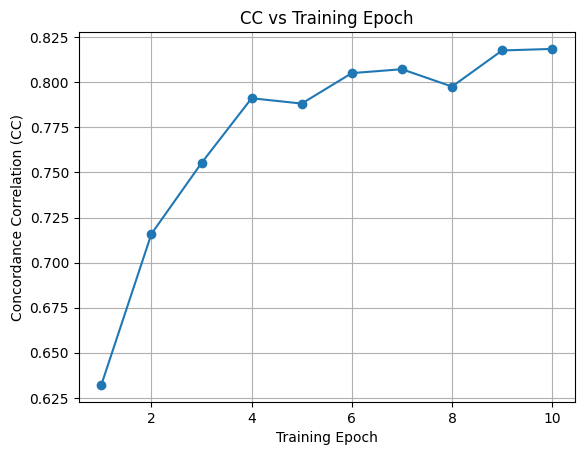

In [ ]:
import matplotlib.pyplot as plt

# Load the metrics from the file
#metrics_path = '/content/ece285/model1/metrics.pkl'
metrics_path = '/content/metrics.pkl'
with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

# Extract the CC scores and training epochs from the metrics
cc_scores = metrics['CC']
epochs = range(1, len(cc_scores) + 1)

# Plot CC vs training epoch
plt.plot(epochs, cc_scores, marker='o')
plt.xlabel('Training Epoch')
plt.ylabel('Concordance Correlation (CC)')
plt.title('CC vs Training Epoch')
plt.grid(True)
plt.show()


## show a saliency example

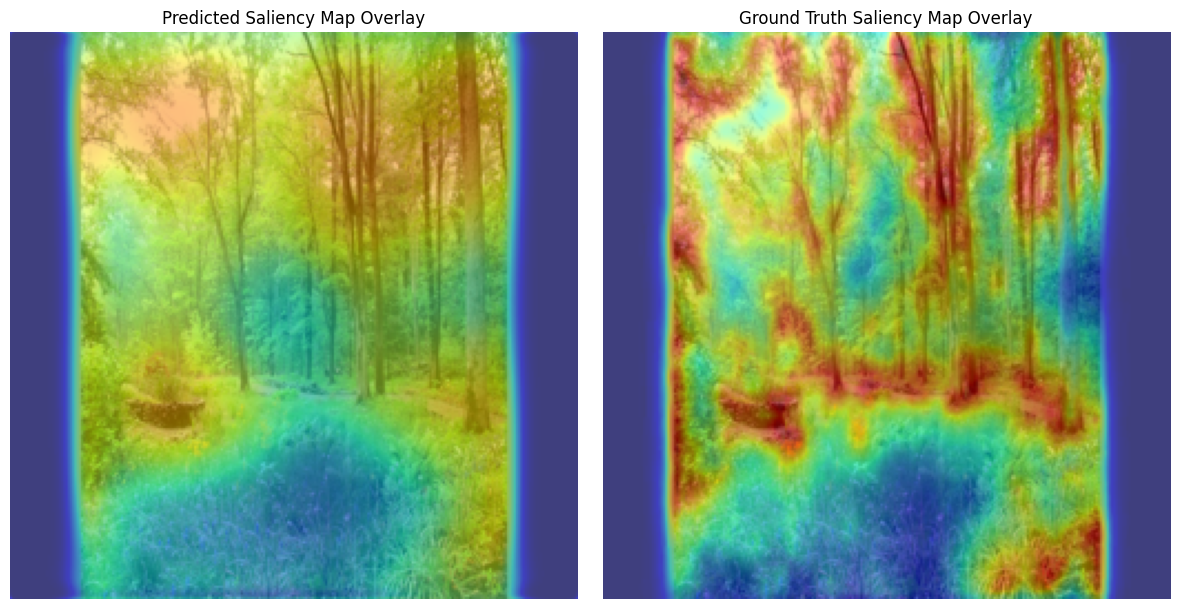

In [ ]:
def get_saliency_map(image):
    normalized_image = image.unsqueeze(0).to(device)
    encoded = encoder(normalized_image)
    saliency_map = decoder(encoded)
    return normalized_image, saliency_map

transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize images to 256x256
    transforms.ToTensor(),           # Convert images to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])


import matplotlib.pyplot as plt
from PIL import ImageEnhance

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).expand_as(tensor).to(tensor.device)
    return tensor * std + mean
def normalize_saliency_map(sal_map):
    # Normalize the saliency map to [0, 255] for visualization
    normalized_sal_map = 255 * (sal_map - sal_map.min()) / (sal_map.max() - sal_map.min())
    return normalized_sal_map
example_path = '/content/ece285/trainSet/Stimuli/OutdoorNatural/035.jpg'
groundtruth_path = '/content/ece285/trainSet/Stimuli/OutdoorNatural/Output/035_SaliencyMap.jpg'
example = Image.open(example_path)
groundtruth  = Image.open(groundtruth_path)

# Get saliency map and the input image
ex = transform(example)
_, sal_map = get_saliency_map(ex)

# Prepare the predicted saliency map
normalized_image = ex.squeeze(0)  # remove batch dimension
denorm_image = denormalize(normalized_image).detach().cpu().permute(1, 2, 0).clamp_(0, 1).numpy()
sal_map = sal_map.detach().cpu().squeeze().numpy()
colored_sal_map = plt.get_cmap('jet')(sal_map)
colored_sal_map = Image.fromarray((colored_sal_map[:, :, :3] * 255).astype(np.uint8))

# Prepare the ground truth saliency map
groundtruth = groundtruth.resize((256, 256))
groundtruth = np.array(groundtruth)
groundtruth = plt.get_cmap('jet')(groundtruth)
groundtruth = Image.fromarray((groundtruth[:, :, :3] * 255).astype(np.uint8))

# Plot the images
plt.figure(figsize=(12, 6))

# Original image with predicted saliency map overlay
plt.subplot(1, 2, 1)
overlay = Image.blend(Image.fromarray((denorm_image * 255).astype(np.uint8)), colored_sal_map.convert("RGB"), alpha=0.5)
plt.imshow(overlay)
plt.title('Predicted Saliency Map Overlay')
plt.axis('off')

# Original image with ground truth saliency map overlay
plt.subplot(1, 2, 2)
overlay = Image.blend(Image.fromarray((denorm_image * 255).astype(np.uint8)), groundtruth.convert("RGB"), alpha=0.5)
plt.imshow(overlay)
plt.title('Ground Truth Saliency Map Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()
